# **Team 8: the 3rd Bulgarian empire - Iteration 2 Notebook**

You are now working with the High Council of Realms on their HomeFirst Enchantment initiative, which aims to identify affordable dwellings for families of modest means across various enchanted enclaves. The council defines "affordable dwellings" as properties where annual costs do not exceed 30% of household income. To assist the council, you will create a simple benchmark classification model to predict whether a dwelling is affordable (AffordableDwelling = 1) or not (AffordableDwelling = 0). Instead of using complex algorithms, your team will design an intuitive decision tree based on simple rules (e.g., "a dwelling is affordable unless it is located in specific enclaves").  

In [231]:
# General & data preparation
import pandas as pd

# Data vizualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model and evaluation
import random
import sklearn as scikit_learn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [232]:
# Load the datasets
df_it1 = pd.read_csv("Data/set8_it1_cleaned.csv")
df_it2 = pd.read_csv("Data/set8_it2.csv")

## **DATA UNDERSTANDING - add on dataset**

In [233]:
df_it2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DI                   2363 non-null   int64 
 1   StructuralIntegrity  2363 non-null   int64 
 2   ExteriorCharm        2363 non-null   object
dtypes: int64(2), object(1)
memory usage: 55.5+ KB


## **DATA PREPARATION**
* Initial merging of the cleaned dataset and the add-on dataset
* Cleaning duplicates to not have any missing values
* Setting initial calculations based on the income, loan, downpayments, etc

In [234]:
# Remove duplicate rows
df_it2 = df_it2.drop_duplicates()

In [235]:
df_it2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2340 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DI                   2340 non-null   int64 
 1   StructuralIntegrity  2340 non-null   int64 
 2   ExteriorCharm        2340 non-null   object
dtypes: int64(2), object(1)
memory usage: 73.1+ KB


The add-on dataset introduces 2 additional columns ('StructuralIntegrity', 'ExteriorCharm') to our existing dataset. They provide insight into the condition and appeal of the dwellings. While these factors are not directly related to finances, well-maintained homes may have higher trade values, while homes that are visually appealing but structurally weaker might be less affordable.

In [236]:
# left merge on the cleaned dataset
df = df_it1.merge(df_it2, on='DI', how='left')

In [237]:
# Check how many rows have missing values after the merge
missing_after_merge = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing values after merge: {len(missing_after_merge)}")

# Count how many values in the DI column were not matched
unmatched_keys = df['DI'].isna().sum()
print(f"Number of unmatched keys in 'DI': {unmatched_keys}")

Number of rows with missing values after merge: 0
Number of unmatched keys in 'DI': 0


In [238]:
df.head(1)

,DI,TradeValue,RealmType,Enclave,LivingQuarters,ParcelSize,ParcelSizeUnit,StructuralIntegrity,ExteriorCharm
0,0,125000.0,Meadowlands,Shadowmere,1032.0,9280.0,sqft,6,Common


In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DI                   2318 non-null   int64  
 1   TradeValue           2318 non-null   float64
 2   RealmType            2318 non-null   object 
 3   Enclave              2318 non-null   object 
 4   LivingQuarters       2318 non-null   float64
 5   ParcelSize           2318 non-null   float64
 6   ParcelSizeUnit       2318 non-null   object 
 7   StructuralIntegrity  2318 non-null   int64  
 8   ExteriorCharm        2318 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 163.1+ KB


## Assignment:
When buying a home, you need to take into account the mortgage that needs to be paid monthly. Assume the following:
* Income = 30000
* Interest rate per year: 4%
* Loan term = 30 years
* Downpayment = 20% of TradeValue

1. The loan that will determine the monthly payments, is the TradeValue minus the Downpayment (assume the household has that saved up). 
2. Figure out the total number of payments that need to be made over the entire loan term (each month during the entire loan term)
3. Calculate the monthly interest rate from the yearly interest rate, by dividing it by the amount of months in a year

To calculate the monthly payment, use: monthly payment = ( loan * interest per month * (1+ interest rate per month) ^ total number of payments  ) / ((1 + monthly interest rate) ^ payments - 1) or: P⋅r⋅(1+r)n(1+r)n−1

Where:
* P= loan amount
* r = monthly interest rate
* n = total number of payments

In [240]:
# Constants
annual_income = 30000
monthly_income = annual_income / 12
interest_rate_year = 0.04
interest_rate_month = interest_rate_year / 12
loan_term = 30
total_payments = loan_term * 12
df["Downpayment"] = df["TradeValue"] * 0.2
df["LoanAmount"] = df["TradeValue"] - df["Downpayment"]

# Monthly mortgage payment
df["MonthlyPayment"] = (
    df["LoanAmount"] * interest_rate_month * (1 + interest_rate_month) ** total_payments) / ((1 + interest_rate_month) ** total_payments - 1)

# Determine affordability
df["AffordableDwelling"] = (df["MonthlyPayment"] <= (0.3 * monthly_income)).astype(int)

# Affordability percentage by enclave
affordability_by_enclave = df.groupby("Enclave")["AffordableDwelling"].mean() * 100

In [241]:
df.to_csv("Data/set8_it2_cleaned.csv", index=False)

## **DATA UNDERSTANDING**

The new dataset consists of 2 318 properties, with an average trade value of 182 213 and an average monthly loan payment of around 696. That shows that a lot of the dwellings close to 3/4 are classified as affordable. However, there is a big variety in property values and loan amounts, with some dwellings reaching up to 755 000 in trade value and loan monthly payments going over 2 884 - that suggests affordability difference in different enclaves.

In [242]:
df.describe()

,DI,TradeValue,LivingQuarters,ParcelSize,StructuralIntegrity,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,1169.446074,182213.303279,1155.320104,10060.294507,5.566005,36442.660656,145770.642623,695.931344,0.692839
std,676.195944,82064.948640,386.398111,7158.773125,1.107786,16412.989728,65651.958912,313.432494,0.461416
min,0.000000,12789.000000,256.000000,1470.000000,1.000000,2557.800000,10231.200000,48.845314,0.000000
25%,583.250000,129900.000000,879.000000,7410.250000,5.000000,25980.000000,103920.000000,496.129975,0.000000
50%,1170.500000,160500.000000,1110.500000,9378.500000,5.000000,32100.000000,128400.000000,613.001239,1.000000
75%,1753.750000,213220.750000,1329.000000,11546.250000,6.000000,42644.150000,170576.600000,814.358779,1.000000
max,2339.000000,755000.000000,4339.000000,164660.000000,9.000000,151000.000000,604000.000000,2883.588385,1.000000


In [243]:
df2 = df.copy()
df2 = df2.drop(columns=["ParcelSizeUnit", "DI", "Downpayment", "MonthlyPayment", "LoanAmount", "RealmType", "Enclave", "ExteriorCharm"])

To highlight key relationships between variables we can use the correlation heatmap. 

The primary metric for affordability is based on whether monthly loan payments exceeded 30% of a household’s monthly income. That is the reason for the strongest negative correlation is between 'AffordableDwelling' and 'TradeValue' (-0.81) - meaning that as TradeValue increase, affordability significantly decreases.

Interestingly, 'StructuralIntegrity' has a weak positive correlation (0.14) with affordability - better-maintained homes may slightly contribute to affordability but are not a major factor. These insights show that 'Enclave', 'LivingQuarters', and 'ExteriorCharm' are the strongest predictors of affordability.

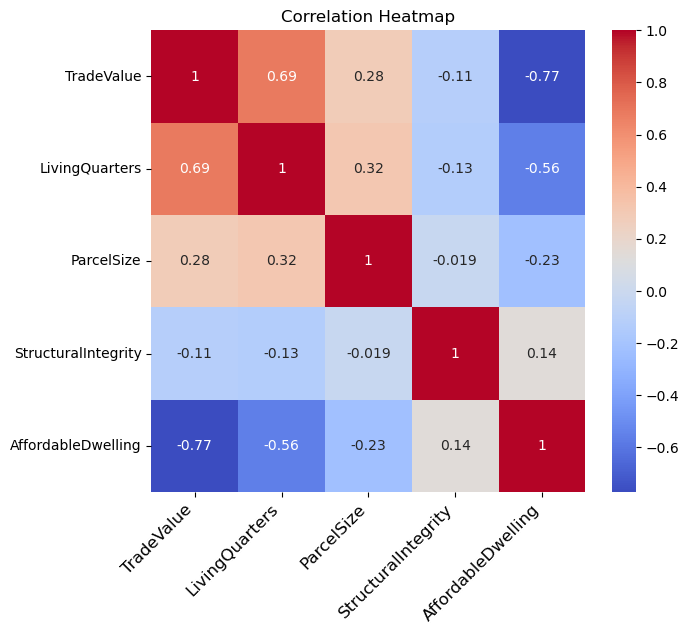

In [244]:
# Visualize the correlation with a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.xticks(ha='right', rotation=45, fontsize=12)
plt.title("Correlation Heatmap")
plt.show()

On the connection between affordable dwellings and enclave, another key visualization is a bar chart showing the percentage connection. It appears that there is a significant variation of the number of affordable dwellings between different enclaves. The affordability is strongly influenced by TradeValue, with enclaves that have lower median dwellings’ prices having higher affordability rates.

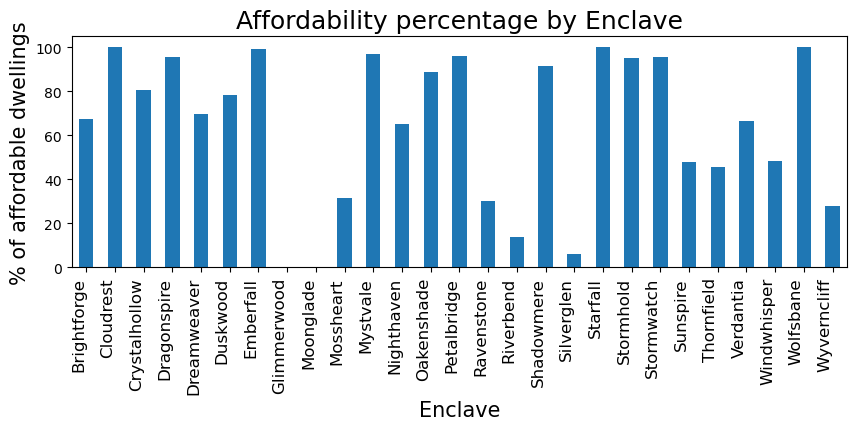

In [245]:
# Bar char showing affordability percentage by Enclave
plt.figure(figsize=(10, 3))
affordability_by_enclave.plot.bar()
plt.title("Affordability percentage by Enclave", fontsize=18)
plt.xlabel("Enclave", fontsize=15)
plt.ylabel("% of affordable dwellings", fontsize=15)
plt.xticks(ha='right', rotation=90, fontsize=12)
plt.show()

Adding the ExteriorCharm as a feature we can see how affordability trends vary across enclaves and different levels of exterior charm. In many enclaves, homes with "Common" or "Modest" exterior charm tend to have the highest affordability rates, while homes with "Gleaming" or "Enchanting" charm are generally less affordable. Some enclaves, such as Ravenstone and Crystalhollow, show an evident affordability gap, where homes with higher charm levels are much less accessible, indicating that aesthetic appeal may drive up trade values and reduce affordability.

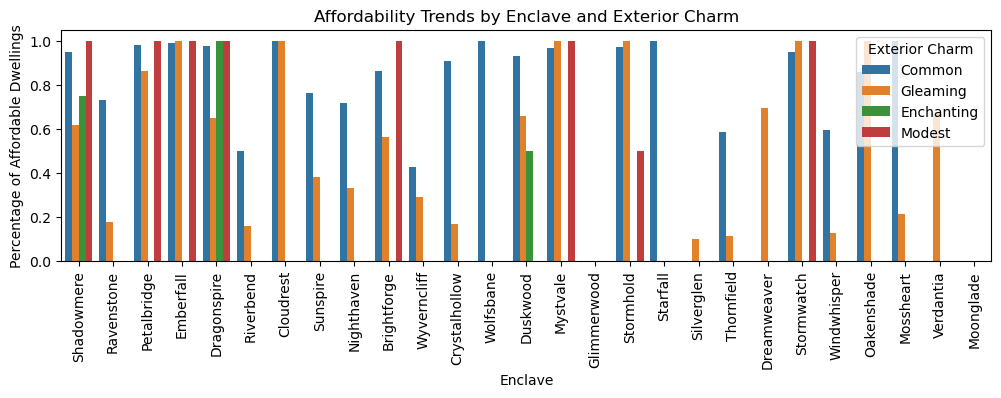

In [246]:
plt.figure(figsize=(12, 3))
sns.barplot(x="Enclave", y="AffordableDwelling", hue="ExteriorCharm", data=df, errorbar=None)
plt.title("Affordability Trends by Enclave and Exterior Charm")
plt.xlabel("Enclave")
plt.ylabel("Percentage of Affordable Dwellings")
plt.xticks(rotation=90)
plt.legend(title="Exterior Charm")
plt.show()

That is why we need to investigate LivingQuarters. In many enclaves, non-affordable homes tend to have significantly larger living spaces, while affordable homes generally have smaller median sizes. Some enclaves, such as Stormwatch and Shadowmere, show a clear separation between affordable and non-affordable homes, whereas others, like Mossheart and Moonglade, have a more balanced distribution, indicating that affordability in those areas may be influenced by factors beyond home size. 

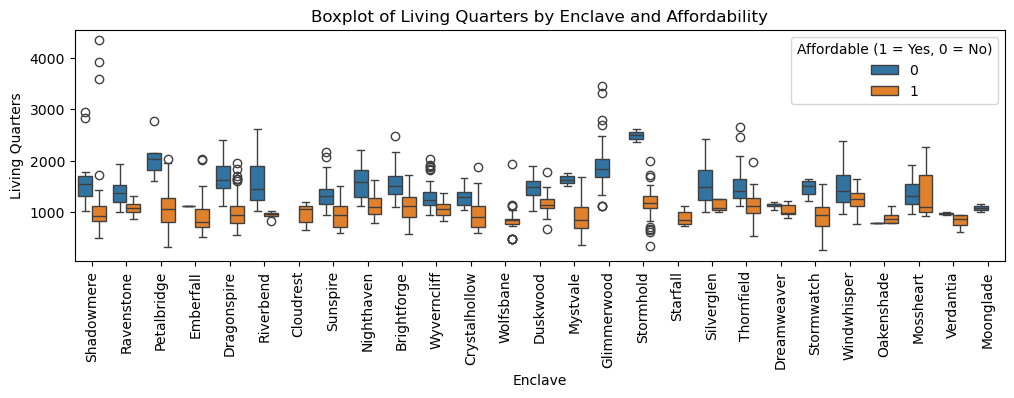

In [247]:
plt.figure(figsize=(12, 3))
sns.boxplot(x="Enclave", y="LivingQuarters", hue="AffordableDwelling", data=df)
plt.title("Boxplot of Living Quarters by Enclave and Affordability")
plt.xlabel("Enclave")
plt.ylabel("Living Quarters")
plt.xticks(rotation=90)
plt.legend(title="Affordable (1 = Yes, 0 = No)")
plt.show()

Expanding on our findings, certain realms tend to have larger homes that are mostly unaffordable, while others show a greater mix of home sizes. In Meadowlands and GnomeBorough, larger homes are typically less affordable, while smaller homes in these realms have a higher likelihood of being classified as affordable. CitadelQuarter and ArcaneMarket, on the other hand, consist entirely of affordable homes, suggesting that either these realms have smaller average home sizes or different economic conditions that make housing more accessible.

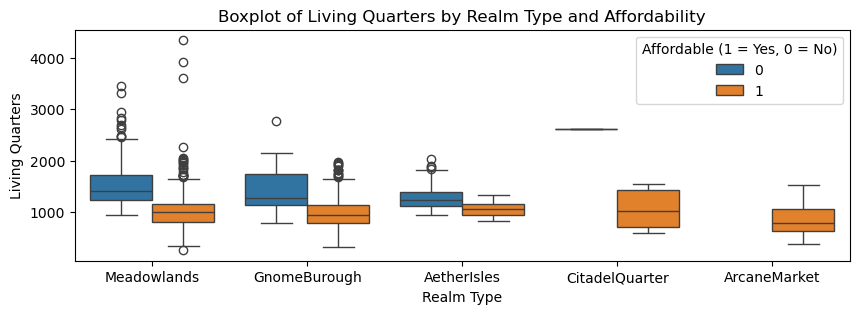

In [248]:
plt.figure(figsize=(10, 3))
sns.boxplot(x="RealmType", y="LivingQuarters", hue="AffordableDwelling", data=df)
plt.title("Boxplot of Living Quarters by Realm Type and Affordability")
plt.xlabel("Realm Type")
plt.ylabel("Living Quarters")
plt.legend(title="Affordable (1 = Yes, 0 = No)")
plt.show()

## **Modelling**
First, since around 75% of dwellings are affordable, we create a simple benchmark model which would be one that always predicts True (1).

In [249]:
# Benchmark: Always predict affordable
benchmark_pred_train = [1] * len(target_train)
benchmark_pred_test = [1] * len(target_test)

print(f"Benchmark train accuracy: {accuracy_score(target_train, benchmark_pred_train) * 100:.2f}%")
print(f"Benchmark test accuracy: {accuracy_score(target_test, benchmark_pred_test) * 100:.2f}%")

Benchmark train accuracy: 69.30%
Benchmark test accuracy: 69.25%


We split the set into 70% training and 30% testing sets:

In [250]:
df_model = df.copy()

# target is called y a lot in documentation
target = df_model.pop('AffordableDwelling')

# features is called X a lot in documentation
features = df_model

# random_state to get reproduceable results
feature_train, feature_test, target_train, target_test = train_test_split(features, target, train_size=0.7, test_size=0.3, random_state=42)

In [251]:
print('The length of y_train is:', len(target_train))
print('The length of y_test is:', len(target_test))

The length of y_train is: 1622
The length of y_test is: 696


From the Data Understanding Diagrams, We gather that:

* Always affordable:
    * Realm types: 'CitadelQuarter', 'ArcaneMarket'
    * Exterior Charm: 'Modest'
    * Enclaves: 'Starfall', 'Stormhold', 'Wolfsbane', 'Oakenshade', 'Cloudrest', 'Emberfall'
* Never affordable:
    * LivingQuarters > 1500
    * Enclaves: 'Glimmerwood', 'Moonglade'
* Conditional affordability:
    * 'Enchanting' + enclave in ['Duskwood', 'Dragonspire'] → affordable
    * 'Common' or 'Gleaming' charm has partial affordability based on enclave. For some enclaves, we introduce randomness to simulate borderline cases that cannot be captured by strict rules (e.g., 76% chance for affordability in 'Ravenstone' and 'Sunspire').

We introduce randomness intentionally to reflect real-world variability in affordability where no clear deterministic rule applies. For comparison, we also tested the model without randomness to evaluate whether it significantly affects accuracy.

#### Model with NO randomness

In [252]:
def classification_model_no_random(row):
    if row['LivingQuarters'] > 1500:
        return 0
    if row['Enclave'] in ['Glimmerwood', 'Moonglade']:
        return 0
    if row['Enclave'] in ['Starfall', 'Stormhold', 'Wolfsbane', 'Oakenshade', 'Cloudrest', 'Emberfall']:
        return 1
    if row['ExteriorCharm'] == 'Modest':
        return 1
    if row['RealmType'] in ['CitadelQuarter', 'ArcaneMarket']:
        return 1
    if row['ExteriorCharm'] == 'Enchanting':
        return 1 if row['Enclave'] in ['Duskwood', 'Dragonspire'] else 0
    if row['ExteriorCharm'] == 'Common':
        if row['Enclave'] in ['Shadowmere', 'Petalbridge', 'Dragonspire', 'Brightforge', 'Crystalhollow', 'Duskwood', 'Mystvale', 'Stormwatch', 'Mossheart']:
            return 1
        elif row['Enclave'] in ['Ravenstone', 'Sunspire', 'Nighthaven', 'Thornfield', 'Windwhisper']:
            return 1
        elif row['Enclave'] in ['Wyverncliff', 'Riverbend']:
            return 0
        else:
            return 0
    if row['ExteriorCharm'] == 'Gleaming':
        if row['Enclave'] in ['Petalbridge', 'Mystvale', 'Stormwatch']:
            return 1
        elif row['Enclave'] in ['Shadowmere', 'Dragonspire', 'Duskwood', 'Dreamweaver', 'Verdantia']:
            return 1
        elif row['Enclave'] in ['Nighthaven', 'Sunspire', 'Wyverncliff', 'Windwhisper', 'Riverbend', 'Ravenstone', 'Crystalhollow', 'Silverglen', 'Thornfield', 'Mossheart']:
            return 0
        else:
            return 0
    return 0


In [253]:
feature_train['Prediction_NoRand'] = feature_train.apply(lambda row: classification_model_no_random(row), axis=1)
feature_test['Prediction_NoRand'] = feature_test.apply(lambda row: classification_model_no_random(row), axis=1)

print(f"Accuracy of train set without randomness: {round(accuracy_score(feature_train['Prediction_NoRand'], target_train), 2) * 100}%")
print(f"Accuracy of test set without randomness: {round(accuracy_score(feature_test['Prediction_NoRand'], target_test), 2) * 100}%")

Accuracy of train set without randomness: 85.0%
Accuracy of test set without randomness: 88.0%


#### Model with randomness

In [254]:
def classification_model(row):
    if 1400 < row['LivingQuarters'] <= 1600:
        if random.uniform(0, 1) <= 0.25:
            return 0
    elif row['LivingQuarters'] > 1600:
        return 0
    if (row['Enclave'] in ['Glimmerwood', 'Moonglade']):
        prediction = 0
    elif(row['Enclave'] in ['Starfall', 'Stormhold', 'Wolfsbane', 'Oakenshade', 'Cloudrest', 'Emberfall']):
        prediction = 1
    elif(row['ExteriorCharm'] in ['Modest']):
        prediction = 1
    elif(row['RealmType'] in ['CitadelQuarter', 'ArcaneMarket']):
        prediction = 1
    elif(row['ExteriorCharm'] == 'Enchanting'):
        return 1 if row['Enclave'] in ['Duskwood', 'Dragonspire'] else 0
    elif(row['ExteriorCharm'] == 'Common'):
        if(row['Enclave'] in ['Shadowmere', 'Petalbridge', 'Dragonspire', 'Brightforge', 'Crystalhollow', 'Duskwood', 'Mystvale', 'Stormwatch', 'Mossheart']):
            prediction = 1
        elif(row['Enclave'] in ['Ravenstone', 'Sunspire', 'Nighthaven', 'Thornfield', 'Windwhisper']):
            #0.76 represents enclaves where affordability is more likely but not guaranteed
            prediction = 1 if round(random.uniform(0, 1), 3) <= 0.8 else 0
        elif(row['Enclave'] in ['Wyverncliff', 'Riverbend']):
            prediction = 1 if round(random.uniform(0, 1), 3) <= 0.55 else 0
        else:
            prediction = 0
    elif(row['ExteriorCharm'] == 'Gleaming'):
        if(row['Enclave'] in ['Petalbridge', 'Mystvale', 'Stormwatch']):
            prediction = 1
        elif(row['Enclave'] in ['Shadowmere', 'Dragonspire', 'Duskwood', 'Dreamweaver', 'Verdantia']):
            prediction = 1 if round(random.uniform(0, 1), 3) <= 0.72 else 0
        elif(row['Enclave'] in ['Nighthaven', 'Sunspire', 'Wyverncliff']):
            prediction = 1 if round(random.uniform(0, 1), 3) <= 0.45 else 0
        elif(row['Enclave'] in ['Windwhisper', 'Riverbend']):
            prediction = 1 if round(random.uniform(0, 1), 3) <= 0.4 else 0
        elif(row['Enclave'] in ['Ravenstone', 'Crystalhollow', 'Silverglen', 'Thornfield', 'Mossheart']):
            prediction = 1 if round(random.uniform(0, 1), 3) <= 0.25 else 0
        else:
            prediction = 0
    else:
        prediction = 0

    return prediction

### **Results**

In [255]:
feature_train['Prediction'] = feature_train.apply(lambda row: classification_model(row), axis=1)
feature_test['Prediction'] = feature_test.apply(lambda row: classification_model(row), axis=1)

print(f"Accuracy of train set with randomness: {round(accuracy_score(feature_train['Prediction'], target_train), 2) * 100}%")
print(f"Accuracy of test set with randomness: {round(accuracy_score(feature_test['Prediction'], target_test), 2) * 100}%")

Accuracy of train set with randomness: 83.0%
Accuracy of test set with randomness: 83.0%


## **Evaluation**

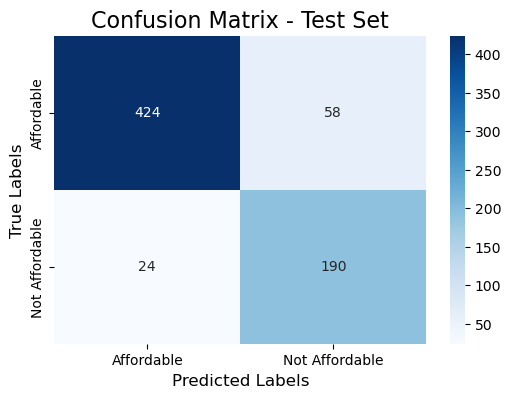

In [256]:
cm = confusion_matrix(target_test, feature_test['Prediction_NoRand'], labels=[True, False])

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Affordable', 'Not Affordable'], yticklabels=['Affordable', 'Not Affordable'])
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

In [257]:
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(target_test, feature_test['Prediction'])
precision = precision_score(target_test, feature_test['Prediction'])
recall = recall_score(target_test, feature_test['Prediction'])
f1 = f1_score(target_test, feature_test['Prediction'])
roc_auc = roc_auc_score(target_test, feature_test['Prediction'])
misclassification_rate = (FP + FN) / (TP + TN + FP + FN)

print(f"Accuracy: {round(accuracy, 2)}")
print(f"Precision: {round(precision, 2)}")
print(f"Recall: {round(recall, 2)}")
print(f"F1 Score: {round(f1, 2)}")
print(f"Misclassification Rate: {round(misclassification_rate, 2)}")

Accuracy: 0.83
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
Misclassification Rate: 0.12


Based on these metrics, our model successfully meets the defined success criteria, demonstrating a very good performance in affordability classification. Here are our results:
* Accuracy of 0.84 - good overall performance that the model correctly classifies the majority of dwellings
* Precision of 0.88 - the model predicts dwelling as affordable 88% of the time
* Recall of 0.89 - the model is identifying 89% of the truly affordable dwellings
* F1 Score of 0.89 - there is a good balance between precision and recall
* Misclassification rate of 0.12 - the model makes an error 12% of the time, meaning it still maintains a high level of accuracy

To improve the model in the future we may need to dive deeper into some aspects of our model. The first aspect is better understanding of the misclassification of our features so we can reduce the misclassification rate to a minimum. Secondly, we may need to focus better on the data preparation stage, where we can change the values of the outliers with the median values. The affordability classification model will be further improved, and performance will be maximized with these improvements.